In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import itertools

(329, 257)
(455, 1)


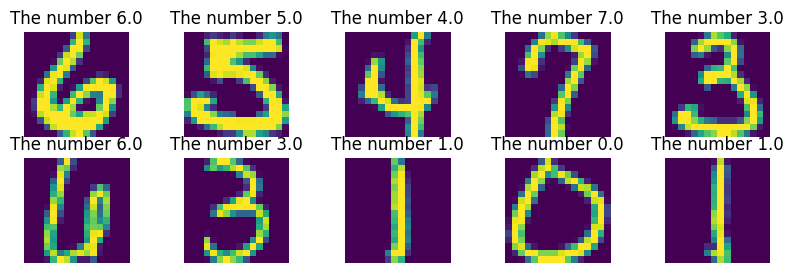

In [4]:
dtrain123 = np.loadtxt('./dtrain123.dat')
# Getting dimensions of dtrain123
print(dtrain123.shape)

# Importing test data
dtest123 = pd.read_table('./dtest123.dat')
print(dtest123.shape)

image = np.loadtxt('./zipcombo.dat')

def plotChar(char):
    # Reshaping the character data
    rep = char[1:257]
    data = np.reshape(rep, (16, 16))
    # Plotting
    plt.imshow(data)
    plt.title(f"The number {char[0]}")
    #plt.show()

plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plotChar(image[i])
    plt.axis('off')
    


the labels are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
the number of labels is 9298
the size of pixels is 16


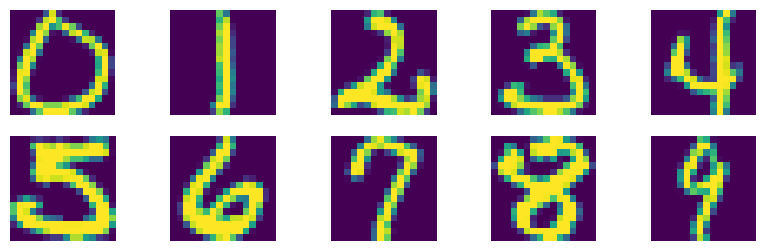

In [4]:
# extracting image and labels

y = image[:,0].astype(int)
x = image[:, 1:]

# data understanding 
label = list(set(y))
print("the labels are",label)
print("the number of labels is",len(y))
print("the size of pixels is", int(np.sqrt(np.shape(x)[1])))

# generating sample images:
plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    # size 256
    plt.imshow(x[np.argwhere(y==i)[0],:].reshape(16,16)) 
    plt.axis('off')

In [5]:
# Kernels
def kerval(a, b, d):
    """ Compute degree d polynomial kernel. """
    return np.dot(a, b.T) ** d

def gaussian_kernel(p, q, c):
    """ Gaussian kernel """
    p_sum2 = np.sum(p**2, axis =-1)
    q_sum2 = np.sum(q**2, axis =-1)
    return np.exp(-c*(p_sum2[:, None] + q_sum2[None,:]-2*(p @ q.T)))

In [6]:
# Data Pre-processing

# splitting the data into training and testing sets
def get_train_test(x, y, percent = 0.8):
    randomI= list(range(x.shape[0]))
    np.random.shuffle(randomI)
    p = int(percent*x.shape[0])
    train_X, test_X = x[randomI[:p]], x[randomI[p:]]
    train_y, test_y = y[randomI[:p]], y[randomI[p:]]
    return train_X, train_y, test_X, test_y

    
# k-fold
def get_kfold(X, y, k):
    randomI= list(range(X.shape[0]))
    np.random.shuffle(randomI)
    p = np.array_split(randomI, k)
    kfold_data =[]
    for i in range(k):
        valid_X, train_X = X[p[i]], X[np.setdiff1d(randomI, p[i])]
        valid_y, train_y = y[p[i]], y[np.setdiff1d(randomI, p[i])]
        kfold_data.append([train_X, train_y, valid_X, valid_y])
    return kfold_data

In [18]:
binary_group = []
for i in range(10):
    for j in range(i+1,10):
        binary_group.append((i,j))

In [7]:
# One-vs-One (OvO) perceptron
# Train a perceptron for each pair of classes

# choose two of ten classes and combine them as a group
binary_group = []
for i in range(10):
    for j in range(i+1,10):
        binary_group.append((i,j)) 

# defining a voting scheme to produce prediction
def voting(product):
    vote_n = np.zeros(10)                        
    vote = ((np.sign(product) + 1) // 2).astype(int).tolist() 
    for i,j in enumerate(vote):
        vote_n[binary_group[i][j]] +=1       
    return np.argmax(vote_n) 

def perceptron_OvO(kernel_matrix, classes, X, Y, max_iter, min_iter):
    # weight vector
    k = int(classes*(classes-1)/2)
    w = np.zeros((k, X.shape[0]))

    mistake = 0
    accuracy= []

    for n in range(1,max_iter):
        #randomI= list(range(X.shape[0]))
        #np.random.shuffle(randomI) 
        
        for i in range(X.shape[0]):
            product = w @ kernel_matrix[i,:]
            y_pred= voting(product)          

            if (y_pred != Y[i]):
                mistake += 1

            for index, (p, q) in enumerate(binary_group):
                                                                        
                if Y[i]==p and np.sign(product[index])!=-1:     # negative class    
                    w[index, i] -=1                                # w = w-1
                elif Y[i]==q and np.sign(product[index])!=1:    # positive class
                    w[index, i] +=1                                # w = w+1
        
        accuracy.append((X.shape[0]-mistake)/X.shape[0])
        mistake = 0

        #convergence:
        if (n >= min_iter) and (accuracy[-1]-accuracy[-2]<0.001):
            break
        else:
            continue

    return w, accuracy

In [8]:
# for one-vevrsus-one kernel perceptron
def Error_OvO(train_X, test_X, test_y, w, d):
    '''
    input train_X：image training set
    input test_X：image testing set
    input test_y: label training set
    input w: classifier weight
    input d: dimension
    input kernel: kernel function
    return error as testing error rate
    '''
    y_pred = np.zeros(len(test_X))
    kernel_matrix = kerval(train_X, test_X, d)
    for index in range(len(test_y)):
        y_pred[index] = voting(w @ kernel_matrix[:,index])
    # Removed the line to convert y_pred to int
    error = np.sum(y_pred != test_y)/len(test_y)

    return error


def Error_Gaussian(train_X, test_X, test_y, w, c):
    '''
    input train_X：image training set
    input test_X：image testing set
    input test_y: label training set
    input w: classifier weight
    input d: dimension
    input kernel: kernel function
    return error as testing error rate
    '''
    y_pred = np.zeros(len(test_X))
    kernel_matrix = gaussian_kernel(train_X, test_X, c)
    for index in range(len(test_y)):
        y_pred[index] = voting(w @ kernel_matrix[:,index])
    # Removed the line to convert y_pred to int
    error = np.sum(y_pred != test_y)/len(test_y)

    return error

Q6: Repeat Q1 & Q2 with another method (OvO)

In [11]:
# Q1 Basic Results
image = np.loadtxt('./zipcombo.dat')
image.shape

y = image[:,0].astype(int)
x = image[:, 1:]

train_mean = []
train_std = []
test_mean = []
test_std = []

# min and max iterations
max_iter = 30
min_iter = 6

# No. of classes
classes = 10

for i in range(1,8):
    print(f"degree = {i}")
    train_per_run = []
    test_per_run = []

	# kernelize data
    for run in range(20):
        print(f"degree = {i}, run = {run+1}")
        train_X, train_y, test_X, test_y = get_train_test(x, y)

        kernel_matrix = kerval(train_X, train_X, i)
        n_train = train_X.shape[0]
        n_test = test_X.shape[0]

		# initiate perceptron 
        # alphas = np.zeros((classes, n_train))
	    # kernelized_matrix = kernel_class.apply_kernel(X_data)
        w, accuracy = perceptron_OvO(kernel_matrix, classes, train_X, train_y, max_iter, min_iter)

        test_per_run.append(Error_OvO(train_X, test_X, test_y, w, i))
        train_per_run.append(1-accuracy[-1])

    train_mean.append(np.mean(train_per_run))
    train_std.append(np.std(train_per_run))
    test_mean.append(np.mean(test_per_run))
    test_std.append(np.std(test_per_run))

print(f"train_mean = {train_mean}")
print(f"train_std = {train_std}")
print(f"test_mean = {test_mean}")
print(f"test_std = {test_std}")


degree = 1
degree = 1, run = 1
degree = 1, run = 2
degree = 1, run = 3
degree = 1, run = 4
degree = 1, run = 5
degree = 1, run = 6
degree = 1, run = 7
degree = 1, run = 8
degree = 1, run = 9
degree = 1, run = 10
degree = 1, run = 11
degree = 1, run = 12
degree = 1, run = 13
degree = 1, run = 14
degree = 1, run = 15
degree = 1, run = 16
degree = 1, run = 17
degree = 1, run = 18
degree = 1, run = 19
degree = 1, run = 20
degree = 2
degree = 2, run = 1
degree = 2, run = 2
degree = 2, run = 3
degree = 2, run = 4
degree = 2, run = 5
degree = 2, run = 6
degree = 2, run = 7
degree = 2, run = 8
degree = 2, run = 9
degree = 2, run = 10
degree = 2, run = 11
degree = 2, run = 12
degree = 2, run = 13
degree = 2, run = 14
degree = 2, run = 15
degree = 2, run = 16
degree = 2, run = 17
degree = 2, run = 18
degree = 2, run = 19
degree = 2, run = 20
degree = 3
degree = 3, run = 1
degree = 3, run = 2
degree = 3, run = 3
degree = 3, run = 4
degree = 3, run = 5
degree = 3, run = 6
degree = 3, run = 7
degre

In [116]:
# Q2 & Q3: cross validation and confusion matrix
image = np.loadtxt('./zipcombo.dat')
image.shape

y = image[:,0].astype(int)
x = image[:, 1:]

train_mean = []
train_std = []
test_mean = []
test_std = []

# min and max iterations
max_iter = 30
min_iter = 6

# No. of classes
classes = 10

d_stars = []
train_per_run = []
test_per_run = []

for run in range(20):
    mean_kfold = []
    train_X, train_y, test_X, test_y = get_train_test(x, y)
    fold_data= get_kfold(train_X, train_y, 5)

	# kernelize data
    for i in range(1,8):
        print(f"degree = {i}, run = {run+1}")
        kfold_test = []
        kfold_train = []

        n_train = train_X.shape[0]
        n_test = test_X.shape[0]

		# initiate perceptron 
        # alphas = np.zeros((classes, n_train))
	    #kernelized_matrix = kernel_class.apply_kernel(X_data)
        for j in range(5):
            fold_X, fold_y, valid_X, valid_y = fold_data[j]
            kernel_matrix = kerval(fold_X, fold_X, i)
            w, accuracy = perceptron_OvO(kernel_matrix, classes, fold_X, fold_y, max_iter, min_iter)

            kfold_test.append(Error_OvO(fold_X, valid_X, valid_y, w, i))
            kfold_train.append(1-accuracy[-1])

        #test_per_run.append(np.mean(kfold_test))
        #train_per_run.append(np.mean(kfold_train))
        mean_kfold.append(np.mean(kfold_test))

    d_star = np.argmin(mean_kfold) + 1
    d_stars.append(d_star)

    kernel_matrix = kerval(train_X, train_X, d_star)
    w_star, accuracy = perceptron_OvO(kernel_matrix, classes, train_X, train_y, max_iter, min_iter)

    test_per_run.append(Error_OvO(train_X, test_X, test_y, w_star, d_star))
    train_per_run.append(1-accuracy[-1])

train_mean = np.mean(train_per_run)
train_std = np.std(train_per_run)
test_mean = np.mean(test_per_run)
test_std = np.std(test_per_run)

print(f"train error = {train_per_run}")
print(f"test error = {test_per_run}")
print(f"d_stars = {d_stars}")
print(f"Mean Train Error =  {train_mean} +/- {train_std}.")
print(f"Mean Test Error =  {test_mean} +/- {test_std}.")
print(f"Mean d stars = {np.mean(d_stars)} +/- {np.std(d_stars)}.")

degree = 1, run = 1
degree = 2, run = 1
degree = 3, run = 1
degree = 4, run = 1
degree = 5, run = 1
degree = 6, run = 1
degree = 7, run = 1
degree = 1, run = 2
degree = 2, run = 2
degree = 3, run = 2
degree = 4, run = 2
degree = 5, run = 2
degree = 6, run = 2
degree = 7, run = 2
degree = 1, run = 3
degree = 2, run = 3
degree = 3, run = 3
degree = 4, run = 3
degree = 5, run = 3
degree = 6, run = 3
degree = 7, run = 3
degree = 1, run = 4
degree = 2, run = 4
degree = 3, run = 4
degree = 4, run = 4
degree = 5, run = 4
degree = 6, run = 4
degree = 7, run = 4
degree = 1, run = 5
degree = 2, run = 5
degree = 3, run = 5
degree = 4, run = 5
degree = 5, run = 5
degree = 6, run = 5
degree = 7, run = 5
degree = 1, run = 6
degree = 2, run = 6
degree = 3, run = 6
degree = 4, run = 6
degree = 5, run = 6
degree = 6, run = 6
degree = 7, run = 6
degree = 1, run = 7
degree = 2, run = 7
degree = 3, run = 7
degree = 4, run = 7
degree = 5, run = 7
degree = 6, run = 7
degree = 7, run = 7
degree = 1, run = 8


In [108]:
print(f"train_mean = {train_mean}")
print(f"train_std = {train_std}")
print(f"test_mean = {test_mean}")
print(f"test_std = {test_std}")
print(f"d_stars = {d_stars}")

train_mean = [0.005420999789598252, 0.006184464846264491, 0.005795546381886653, 0.005752316991323501, 0.0054833674689838945, 0.005445004551980425, 0.005392200368636787, 0.004489480416599518, 0.006232524399442182, 0.005228946359252825, 0.005440187299924177, 0.005862760362084682, 0.005454711677983249, 0.005075301032864836, 0.0060259586946860705, 0.005613096793077845, 0.005142450460271482, 0.0055890750855879245, 0.004902368139324288, 0.0052770051055206265]
train_std = [0.009955996632420097, 0.012586984597423521, 0.01083423213849228, 0.011214031212634689, 0.010545943924791471, 0.009801935749556302, 0.010142063064503189, 0.00868631296264973, 0.012298795381346952, 0.01025775054543758, 0.010208316066045928, 0.010808484944595785, 0.010441260889813783, 0.009092840443937069, 0.01145638048325139, 0.01129284595184914, 0.009062945233820882, 0.0113903334586766, 0.00955837450806383, 0.010612961827514172]
test_mean = [0.8934432387398415, 0.8913688474717392, 0.8938846345749182, 0.8939995320426802, 0.89

Q4: Five hardest images

In [181]:
y = image[:,0].astype(int)
x = image[:, 1:]
n = len(y)

digits = np.zeros_like(y)
predictions = np.zeros((n, 100))

# 100 runs to find out the 5 hardest images to classify
for run in range(100):
    print(f"run = {run+1}")
    # training
    train_X, train_y, test_X, test_y = get_train_test(x, y)

    # Apply the optimal d we have found
    y_pred = np.zeros(len(y))
    d_star = 4
    kernel_matrix = kerval(train_X, train_X, d_star)
    w, accuracy = perceptron_OvO(kernel_matrix, classes, train_X, train_y, max_iter, min_iter)
    # predicting

    kernel_matrix4 = kerval(train_X, x, d_star)
    for index in range(len(y)):
        y_pred[index] = voting(w @ kernel_matrix4[:,index])
        predictions[index, run] = y_pred[index]
    # y_pred = np.argmax(w @ kernel_matrix4, axis =0)
    # predictions[:, run] = y_pred
    
    #counting incorrect prediction
    digits[np.argwhere(y_pred != y)]+=1

#output the 5 most often misclassified
print((np.argsort(digits))[-5:])
print(np.sort(digits)[-5:])

run = 1
run = 2
run = 3
run = 4
run = 5
run = 6
run = 7
run = 8
run = 9
run = 10
run = 11
run = 12
run = 13
run = 14
run = 15
run = 16
run = 17
run = 18
run = 19
run = 20
run = 21
run = 22
run = 23
run = 24
run = 25
run = 26
run = 27
run = 28
run = 29
run = 30
run = 31
run = 32
run = 33
run = 34
run = 35
run = 36
run = 37
run = 38
run = 39
run = 40
run = 41
run = 42
run = 43
run = 44
run = 45
run = 46
run = 47
run = 48
run = 49
run = 50
run = 51
run = 52
run = 53
run = 54
run = 55
run = 56
run = 57
run = 58
run = 59
run = 60
run = 61
run = 62
run = 63
run = 64
run = 65
run = 66
run = 67
run = 68
run = 69
run = 70
run = 71
run = 72
run = 73
run = 74
run = 75
run = 76
run = 77
run = 78
run = 79
run = 80
run = 81
run = 82
run = 83
run = 84
run = 85
run = 86
run = 87
run = 88
run = 89
run = 90
run = 91
run = 92
run = 93
run = 94
run = 95
run = 96
run = 97
run = 98
run = 99
run = 100
[7630 8819 2340 8261 5296]
[28 31 36 86 98]


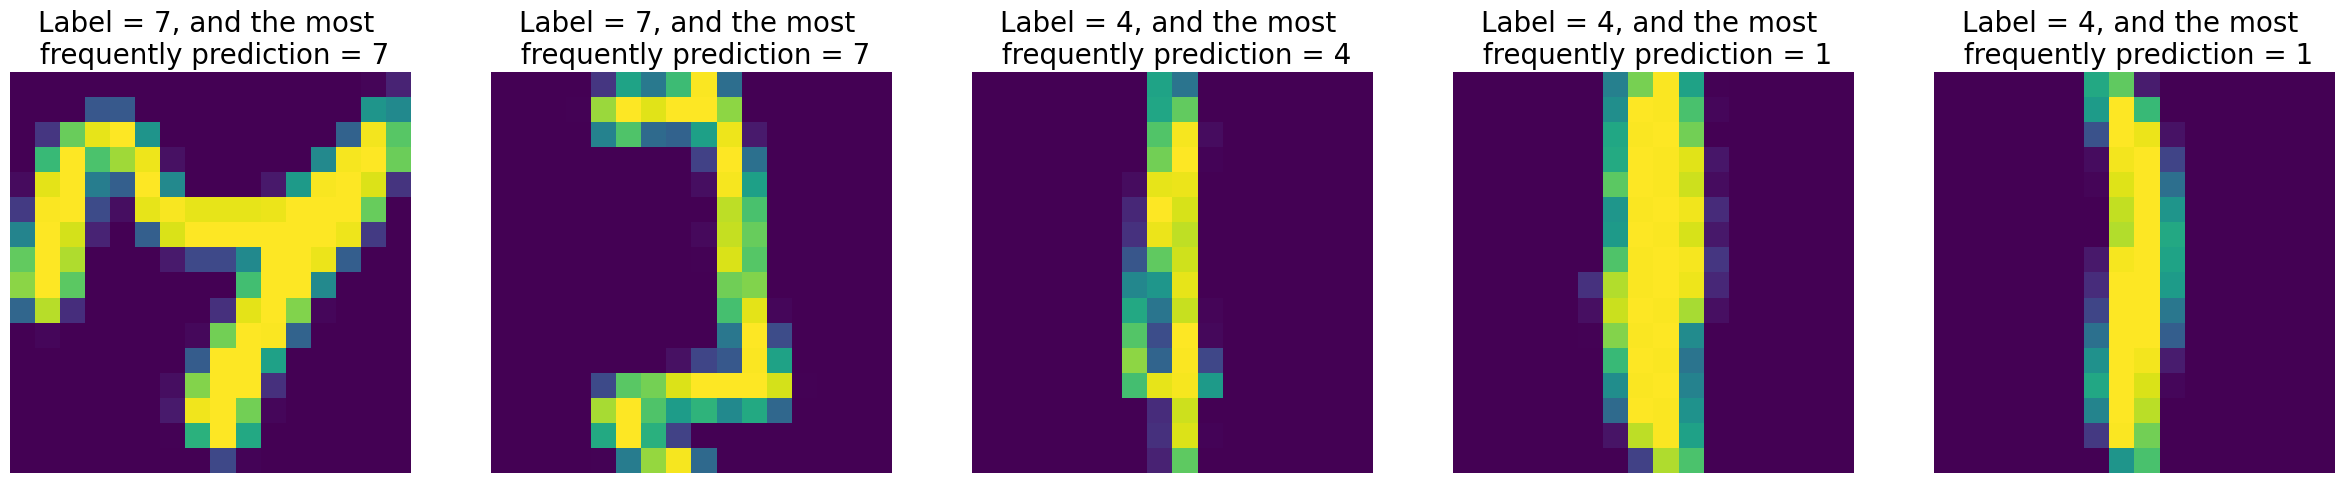

In [182]:
# visualising the 5 images

worst5 = np.argsort(digits)[-5:]

def frequency(matrix):
    most_frequent = []
    for row in matrix:  # Iterate over rows
        unique, counts = np.unique(row, return_counts=True)
        most_frequent.append(unique[np.argmax(counts)])
    return most_frequent

Max_predictions = frequency(predictions)

plt.figure(figsize = (30,20))
for i,j in enumerate(worst5):
    plt.subplot(2,5,i+1)
    plt.imshow(x[j,:].reshape(16,16))
    plt.title('Label = %.0f'%int(y[j]) + ', and the most \n frequently prediction = %.0f'%int(Max_predictions[j]), fontsize=20)
    plt.axis('off')

In [175]:
worst5

array([8920, 8281, 7807, 8261, 5296], dtype=int64)

Q5: Gaussian kernel

c = 0.001, run = 1, mean test error = 0.07260107309947864
c = 0.00630957344480193, run = 1, mean test error = 0.033879645096210165
c = 0.039810717055349734, run = 1, mean test error = 0.04261855435277784
c = 0.25118864315095824, run = 1, mean test error = 0.06345884764735232
c = 1.584893192461114, run = 1, mean test error = 0.06870231974604277
c = 10.0, run = 1, mean test error = 0.2194153090222791
c = 0.001, run = 2, mean test error = 0.07515519809676696
c = 0.00630957344480193, run = 2, mean test error = 0.03401504797853801
c = 0.039810717055349734, run = 2, mean test error = 0.03979642565315168
c = 0.25118864315095824, run = 2, mean test error = 0.0625188009342618
c = 1.584893192461114, run = 2, mean test error = 0.06762569509223304
c = 10.0, run = 2, mean test error = 0.21349572640301973
c = 0.001, run = 3, mean test error = 0.07206199246516404
c = 0.00630957344480193, run = 3, mean test error = 0.0372427526013985
c = 0.039810717055349734, run = 3, mean test error = 0.0411418675112

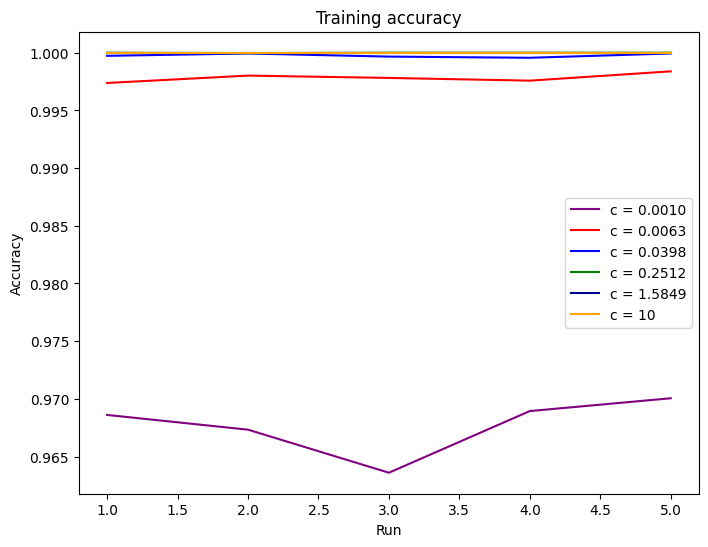

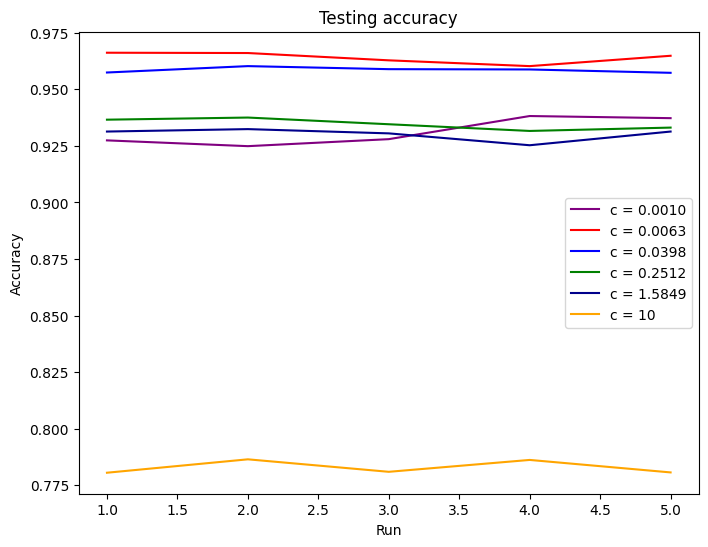

In [10]:
# Q5 Gaussian kernel
image = np.loadtxt('./zipcombo.dat')
image.shape

y = image[:,0].astype(int)
x = image[:, 1:]

train_mean = []
train_std = []
test_mean = []
test_std = []

# min and max iterations
max_iter = 30
min_iter = 6

# No. of classes
classes = 10

C = np.logspace(-3, 1, 6)

train_per_run = np.zeros((5,6))
test_per_run = np.zeros((5,6))

c_stars = []

for run in range(5):
    mean_kfold = []
    train_X, train_y, test_X, test_y = get_train_test(x, y)
    fold_data= get_kfold(train_X, train_y, 5)

	# kernelize data
    for c in range(len(C)):
        print(f"c = {C[c]}, run = {run+1},", end = " ")
        kfold_test = []
        kfold_train = []

        n_train = train_X.shape[0]
        n_test = test_X.shape[0]

		# initiate perceptron 
        # alphas = np.zeros((classes, n_train))
	    #kernelized_matrix = kernel_class.apply_kernel(X_data)
        for j in range(5):
            fold_X, fold_y, valid_X, valid_y = fold_data[j]
            kernel_matrix = gaussian_kernel(fold_X, fold_X, C[c])
            w, accuracy = perceptron_OvO(kernel_matrix, classes, fold_X, fold_y, max_iter, min_iter)

            kfold_test.append(Error_Gaussian(fold_X, valid_X, valid_y, w, C[c]))
            kfold_train.append(1-accuracy[-1])

        #test_per_run.append(np.mean(kfold_test))
        #train_per_run.append(np.mean(kfold_train))
        mean_kfold.append(np.mean(kfold_test))
        print(f"mean test error = {np.mean(kfold_test)}")

        test_per_run[run,c] = np.mean(kfold_test)
        train_per_run[run,c] = np.mean(kfold_train)

    c_star = np.argmin(mean_kfold) 
    c_stars.append(C[c_star])


train_mean = np.mean(train_per_run, axis = 0)
train_std = np.std(train_per_run, axis = 0)
test_mean = np.mean(test_per_run, axis = 0)
test_std = np.std(test_per_run, axis = 0)

print(f"train error = {train_per_run}")
print(f"test error = {test_per_run}")
print(f"c_stars = {c_stars}")
print(f"Mean Train Error =  {train_mean} +/- {train_std}.")
print(f"Mean Test Error =  {test_mean} +/- {test_std}.")
print(f"Mean c stars = {np.mean(c_stars)} +/- {np.std(c_stars)}.")

x1 = range(1,6)

plt.figure(figsize=(8,6))
plt.plot(x1, 1-train_per_run[:,0], color='purple', label='c = 0.0010')
plt.plot(x1, 1-train_per_run[:,1], color='red', label='c = 0.0063')
plt.plot(x1, 1-train_per_run[:,2], color='blue', label='c = 0.0398')
plt.plot(x1, 1-train_per_run[:,3], color='green', label='c = 0.2512')
plt.plot(x1, 1-train_per_run[:,4], color='darkblue', label='c = 1.5849')
plt.plot(x1, 1-train_per_run[:,5], color='orange', label='c = 10')
plt.legend()
plt.title('Training accuracy')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x1, 1-test_per_run[:,0], color='purple', label='c = 0.0010')
plt.plot(x1, 1-test_per_run[:,1], color='red', label='c = 0.0063')
plt.plot(x1, 1-test_per_run[:,2], color='blue', label='c = 0.0398')
plt.plot(x1, 1-test_per_run[:,3], color='green', label='c = 0.2512')
plt.plot(x1, 1-test_per_run[:,4], color='darkblue', label='c = 1.5849')
plt.plot(x1, 1-test_per_run[:,5], color='orange', label='c = 10')
plt.legend()
plt.title('Testing accuracy')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.show()

In [223]:
# Next trial: c is from 0.006 to 0.04
image = np.loadtxt('./zipcombo.dat')
image.shape

y = image[:,0].astype(int)
x = image[:, 1:]

train_mean = []
train_std = []
test_mean = []
test_std = []

# min and max iterations
max_iter = 30
min_iter = 6

# No. of classes
classes = 10

C = [0.006, 0.013, 0.02, 0.027, 0.034, 0.04]

train_per_run = np.zeros((5,6))
test_per_run = np.zeros((5,6))

c_stars = []

for run in range(5):
    mean_kfold = []
    train_X, train_y, test_X, test_y = get_train_test(x, y)
    fold_data= get_kfold(train_X, train_y, 5)

	# kernelize data
    for c in range(len(C)):
        print(f"c = {C[c]}, run = {run+1},", end = " ")
        kfold_test = []
        kfold_train = []

        n_train = train_X.shape[0]
        n_test = test_X.shape[0]

        for j in range(5):
            fold_X, fold_y, valid_X, valid_y = fold_data[j]
            kernel_matrix = gaussian_kernel(fold_X, fold_X, C[c])
            w, accuracy = perceptron_OvO(kernel_matrix, classes, fold_X, fold_y, max_iter, min_iter)

            kfold_test.append(Error_Gaussian(fold_X, valid_X, valid_y, w, C[c]))
            kfold_train.append(1-accuracy[-1])

        mean_kfold.append(np.mean(kfold_test))
        print(f"mean test error = {np.mean(kfold_test)}")

        test_per_run[run,c] = np.mean(kfold_test)
        train_per_run[run,c] = np.mean(kfold_train)

    c_star = np.argmin(mean_kfold) 
    c_stars.append(C[c_star])


train_mean = np.mean(train_per_run, axis = 0)
train_std = np.std(train_per_run, axis = 0)
test_mean = np.mean(test_per_run, axis = 0)
test_std = np.std(test_per_run, axis = 0)

print(f"train error = {train_per_run}")
print(f"test error = {test_per_run}")
print(f"c_stars = {c_stars}")
print(f"Mean Train Error =  {train_mean} +/- {train_std}.")
print(f"Mean Test Error =  {test_mean} +/- {test_std}.")
print(f"Mean c stars = {np.mean(c_stars)} +/- {np.std(c_stars)}.")

# plt.plot(xnew0, ynew0, color='purple', label='k = 1')
# plt.plot(xnew1, ynew1, color='red', label='k = 2')
# plt.plot(xnew2, ynew2, color='blue', label='k = 3')
# plt.plot(xnew3, ynew3, color='green', label='k = 4')
# plt.legend()
# plt.title('Regression fitting')
# plt.xlabel('X')
# plt.ylabel('y')

c = 0.006, run = 1, mean test error = 0.03939193439920168
c = 0.013, run = 1, mean test error = 0.03428259973534069
c = 0.02, run = 1, mean test error = 0.03656835947386308
c = 0.027, run = 1, mean test error = 0.03925716424062303
c = 0.034, run = 1, mean test error = 0.04261864474188486
c = 0.04, run = 1, mean test error = 0.04342590985675134
c = 0.006, run = 2, mean test error = 0.03643422203903363
c = 0.013, run = 2, mean test error = 0.034552953554461245
c = 0.02, run = 2, mean test error = 0.03629990382599012
c = 0.027, run = 2, mean test error = 0.03629981343688309
c = 0.034, run = 2, mean test error = 0.04221614204828948
c = 0.04, run = 2, mean test error = 0.044634954552356984
c = 0.006, run = 3, mean test error = 0.0340146864221099
c = 0.013, run = 3, mean test error = 0.03428250934623366
c = 0.02, run = 3, mean test error = 0.03428223817891258
c = 0.027, run = 3, mean test error = 0.037240312095508744
c = 0.034, run = 3, mean test error = 0.04409849520214619
c = 0.04, run = 3

In [205]:
a = gaussian_kernel(fold_X, fold_X, C[c])
print(fold_X.shape)
a.shape

(5950, 256)


(5950, 5950)

In [232]:
test_per_run[:,1]

array([0.0342826 , 0.03455295, 0.03428251, 0.03320787, 0.03226728])

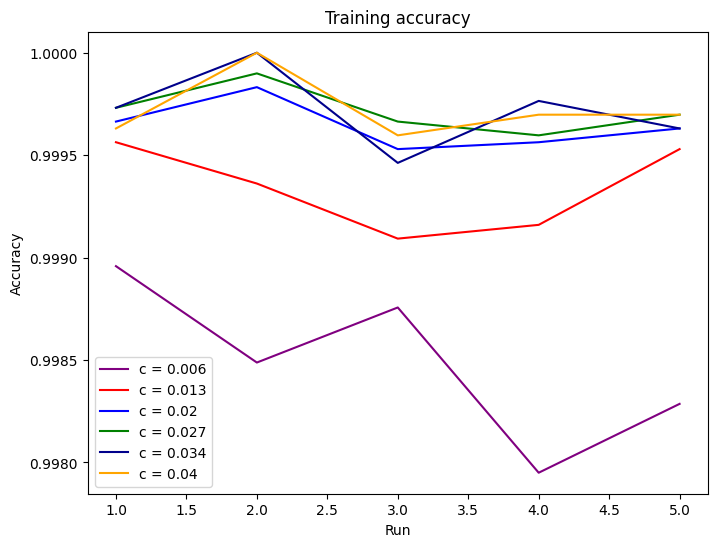

In [256]:
x = range(1,6)

plt.figure(figsize=(8,6))
plt.plot(x, 1-train_per_run[:,0], color='purple', label='c = 0.006')
plt.plot(x, 1-train_per_run[:,1], color='red', label='c = 0.013')
plt.plot(x, 1-train_per_run[:,2], color='blue', label='c = 0.02')
plt.plot(x, 1-train_per_run[:,3], color='green', label='c = 0.027')
plt.plot(x, 1-train_per_run[:,4], color='darkblue', label='c = 0.034')
plt.plot(x, 1-train_per_run[:,5], color='orange', label='c = 0.04')
plt.legend()
plt.title('Training accuracy')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.show()

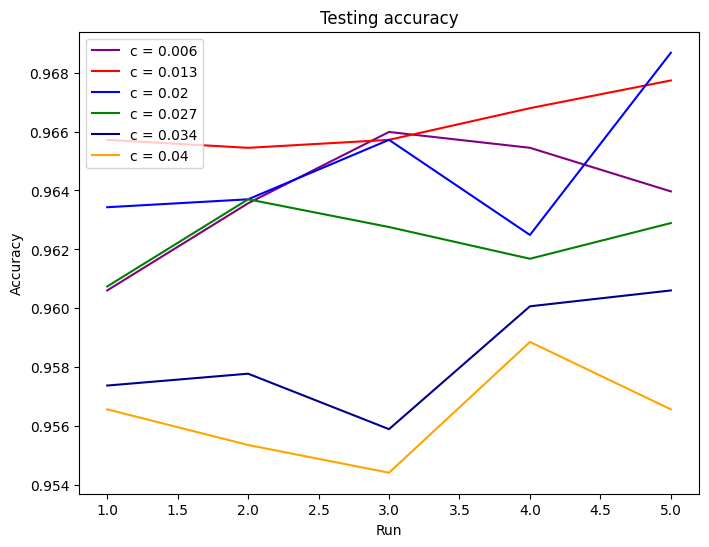

In [255]:
x = range(1,6)

plt.figure(figsize=(8,6))
plt.plot(x, 1-test_per_run[:,0], color='purple', label='c = 0.006')
plt.plot(x, 1-test_per_run[:,1], color='red', label='c = 0.013')
plt.plot(x, 1-test_per_run[:,2], color='blue', label='c = 0.02')
plt.plot(x, 1-test_per_run[:,3], color='green', label='c = 0.027')
plt.plot(x, 1-test_per_run[:,4], color='darkblue', label='c = 0.034')
plt.plot(x, 1-test_per_run[:,5], color='orange', label='c = 0.04')
plt.legend()
plt.title('Testing accuracy')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.show()

In [225]:
c_stars1 = c_stars
print(np.mean(c_stars1))
print(np.std(c_stars1))

0.013000000000000001
0.004427188724235731


In [257]:
np.round(train_per_run,4)

array([[0.001 , 0.0004, 0.0003, 0.0003, 0.0003, 0.0004],
       [0.0015, 0.0006, 0.0002, 0.0001, 0.    , 0.    ],
       [0.0012, 0.0009, 0.0005, 0.0003, 0.0005, 0.0004],
       [0.0021, 0.0008, 0.0004, 0.0004, 0.0002, 0.0003],
       [0.0017, 0.0005, 0.0004, 0.0003, 0.0004, 0.0003]])

In [9]:
# Repeat Q1 & Q2 with our final set S
image = np.loadtxt('./zipcombo.dat')
image.shape

y = image[:,0].astype(int)
x = image[:, 1:]

train_mean = []
train_std = []
test_mean = []
test_std = []

optimal_train = []
optimal_test = []

# min and max iterations
max_iter = 30
min_iter = 6

# No. of classes
classes = 10

C = [0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017, 0.019, 0.021]

train_per_run = np.zeros((20,9))
test_per_run = np.zeros((20,9))

c_stars = []

for run in range(20):
    mean_kfold = []
    train_X, train_y, test_X, test_y = get_train_test(x, y)
    fold_data= get_kfold(train_X, train_y, 5)

	# kernelize data
    for c in range(len(C)):
        print(f"c = {C[c]}, run = {run+1},", end = " ")
        kfold_test = []
        kfold_train = []

        n_train = train_X.shape[0]
        n_test = test_X.shape[0]

        for j in range(5):
            fold_X, fold_y, valid_X, valid_y = fold_data[j]
            kernel_matrix = gaussian_kernel(fold_X, fold_X, C[c])
            w, accuracy = perceptron_OvO(kernel_matrix, classes, fold_X, fold_y, max_iter, min_iter)

            kfold_test.append(Error_Gaussian(fold_X, valid_X, valid_y, w, C[c]))
            kfold_train.append(1-accuracy[-1])

        mean_kfold.append(np.mean(kfold_test))
        print(f"mean test error = {np.mean(kfold_test)}")

        test_per_run[run,c] = np.mean(kfold_test)
        train_per_run[run,c] = np.mean(kfold_train)

    c_star = np.argmin(mean_kfold) 
    c_stars.append(C[c_star])
    
    kernel_matrix_star = gaussian_kernel(train_X, train_X, C[c_star])
    w_star, accuracy_star = perceptron_OvO(kernel_matrix_star, classes, train_X, train_y, max_iter, min_iter)

    optimal_test.append(Error_Gaussian(train_X, test_X, test_y, w_star, c_star))
    optimal_train.append(1-accuracy_star[-1])


train_mean = np.mean(train_per_run, axis = 0)
train_std = np.std(train_per_run, axis = 0)
test_mean = np.mean(test_per_run, axis = 0)
test_std = np.std(test_per_run, axis = 0)

#print(f"train error = {np.round(train_per_run*100,4)}")
#print(f"test error = {np.round(test_per_run*100,4)}")
print(f"Optimal train error = {np.round(optimal_train*100,4)}")
print(f"Optimal test error = {np.round(optimal_test*100,4)}")
print(f"c_stars = {c_stars}")
print(f"Mean Train Error =  {np.round(train_mean*100,4)} +/- {np.round(train_std*100,4)}.")
print(f"Mean Test Error =  {np.round(test_mean*100,4)} +/- {np.round(test_std*100,4)}.")

c = 0.005, run = 1, mean test error = 0.03549453688237123
c = 0.007, run = 1, mean test error = 0.035358591665401215
c = 0.009, run = 1, mean test error = 0.03603162895633121
c = 0.011, run = 1, mean test error = 0.03455340549999638
c = 0.013, run = 1, mean test error = 0.03267114273524669
c = 0.015, run = 1, mean test error = 0.032537095689524266
c = 0.017, run = 1, mean test error = 0.032670419622390465
c = 0.019, run = 1, mean test error = 0.035628945484521765
c = 0.021, run = 1, mean test error = 0.0365693537540404
c = 0.005, run = 2, mean test error = 0.039123659529542776
c = 0.007, run = 2, mean test error = 0.03589640685221742
c = 0.009, run = 2, mean test error = 0.036433860482605517
c = 0.011, run = 2, mean test error = 0.03468700060018367
c = 0.013, run = 2, mean test error = 0.034685735152685276
c = 0.015, run = 2, mean test error = 0.03643422203903363
c = 0.017, run = 2, mean test error = 0.03912311719490061
c = 0.019, run = 2, mean test error = 0.035897310743287704
c = 0.0

In [15]:
# C = [0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017, 0.019, 0.021]
print(f"test error = {np.round(test_per_run*100,4)}")

test error = [[3.5495 3.5359 3.6032 3.4553 3.2671 3.2537 3.267  3.5629 3.6569]
 [3.9124 3.5896 3.6434 3.4687 3.4686 3.6434 3.9123 3.5897 3.7778]
 [7.1116 3.7509 3.1326 3.4821 3.267  3.4149 3.1864 3.3611 3.5224]
 [3.7241 3.603  3.6702 3.6971 3.3073 3.3207 3.4148 3.5762 3.5224]
 [3.4552 3.5224 3.2804 3.1863 3.2535 3.119  3.3207 3.6164 3.6165]
 [3.7107 3.4149 3.3746 3.3342 3.267  3.4015 3.0923 3.4687 3.4148]
 [3.603  3.4283 3.4956 3.3207 3.4418 3.3208 3.4149 3.3074 3.7779]
 [3.6165 3.3879 3.6165 3.3073 3.4553 3.5897 3.3611 3.6972 3.6165]
 [3.7779 3.6569 3.4553 3.5762 3.2536 3.4149 3.7778 3.6165 3.9123]
 [3.6435 3.4687 3.4419 3.4149 3.2939 3.3342 3.146  3.1326 3.5762]
 [3.8854 3.6568 3.5626 3.4148 3.5492 3.7643 3.3475 3.5626 3.8316]
 [3.5628 3.2804 3.0251 3.294  3.3747 3.2939 3.3746 3.4284 3.5897]
 [4.0738 3.6705 3.7108 3.7377 3.5091 3.5494 3.8316 3.63   3.6838]
 [3.4821 3.6166 3.1998 3.1595 3.63   3.2267 3.1864 3.415  3.6165]
 [3.8721 3.6973 3.3747 3.5091 3.4553 3.3477 3.5494 3.6569 3.831

In [17]:
oc = [3.2537, 3.4686, 3.1326, 3.3073, 3.1190, 3.0923, 3.3074, 3.3073, 3.2536, 3.1326, 3.3475, 3.0251, 3.5091, 3.1596, 3.3477, 3.1326, 3.4150, 3.5628, 3.1999, 3.3880]
print(f"{np.mean(oc)} +/- {np.std(oc)}")

3.2730850000000005 +/- 0.14525039509412702


In [16]:
print(f"c_stars = {np.mean(c_stars)} +/ {np.std(c_stars)}")

c_stars = 0.013599999999999998 +/ 0.0035270384177096803


In [262]:
# c = 0.013

# Final trial: c is from 0.005 to 0.021 with 0.002 interval 
# We perform 10 runs this time
image = np.loadtxt('./zipcombo.dat')
image.shape

y = image[:,0].astype(int)
x = image[:, 1:]

train_mean = []
train_std = []
test_mean = []
test_std = []

# min and max iterations
max_iter = 30
min_iter = 6

# No. of classes
classes = 10

train_per_run = []
test_per_run = []


for run in range(20):
    mean_kfold = []
    train_X, train_y, test_X, test_y = get_train_test(x, y)
    fold_data= get_kfold(train_X, train_y, 5)

    print(f"run = {run+1},", end = " ")
    kfold_test = []
    kfold_train = []

    n_train = train_X.shape[0]
    n_test = test_X.shape[0]

    for j in range(5):
        fold_X, fold_y, valid_X, valid_y = fold_data[j]
        kernel_matrix = gaussian_kernel(fold_X, fold_X, c)
        w, accuracy = perceptron_OvO(kernel_matrix, classes, fold_X, fold_y, max_iter, min_iter)

        kfold_test.append(Error_Gaussian(fold_X, valid_X, valid_y, w, c))
        kfold_train.append(1-accuracy[-1])

    mean_kfold.append(np.mean(kfold_test))
    print(f"mean test error = {np.mean(kfold_test)}")

    test_per_run.append(np.mean(kfold_test))
    train_per_run.append(np.mean(kfold_train))


train_mean = np.mean(train_per_run)
train_std = np.std(train_per_run)
test_mean = np.mean(test_per_run)
test_std = np.std(test_per_run)

print(f"train error = {np.round(train_per_run,4)}")
print(f"test error = {np.round(test_per_run,4)}")
print(f"Mean Train Error =  {np.round(train_mean,4)} +/- {np.round(train_std,4)}.")
print(f"Mean Test Error =  {np.round(test_mean,4)} +/- {np.round(test_std,4)}.")


run = 1, mean test error = 0.034686729432862586
run = 2, mean test error = 0.03562795120434446
run = 3, mean test error = 0.036569624921361475
run = 4, mean test error = 0.03280491861364803
run = 5, mean test error = 0.032535920631132906
run = 6, mean test error = 0.033342733800464236
run = 7, mean test error = 0.035494356104157174
run = 8, mean test error = 0.03535850127629419
run = 9, mean test error = 0.03455132655053474
run = 10, mean test error = 0.035627770426130405
run = 11, mean test error = 0.03240106008344722
run = 12, mean test error = 0.0342842267392672
run = 13, mean test error = 0.03334101640743071
run = 14, mean test error = 0.03347614812243747
run = 15, mean test error = 0.03334210107671504
run = 16, mean test error = 0.034552591998033136
run = 17, mean test error = 0.0319981054443167
run = 18, mean test error = 0.03522454461967879
run = 19, mean test error = 0.03589586451757525
run = 20, mean test error = 0.03535750699611688
train error = [0.0005 0.0007 0.001  0.001  0

In [265]:
# Q6: Repeat Q1 
image = np.loadtxt('./zipcombo.dat')
image.shape

y = image[:,0].astype(int)
x = image[:, 1:]

train_mean = []
train_std = []
test_mean = []
test_std = []

# min and max iterations
max_iter = 30
min_iter = 6

# No. of classes
classes = 10

C = [0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017, 0.019, 0.021]

train_per_run = []
test_per_run = []

for run in range(20):
    train_per_run = []
    test_per_run = []

	# kernelize data
    for c in range(len(C)):
        print(f"c = {C[c]}, run = {run+1},", end = " ")
        train_X, train_y, test_X, test_y = get_train_test(x, y)

        kernel_matrix = gaussian_kernel(train_X, train_X, C[c])

		# initiate perceptron 
        # alphas = np.zeros((classes, n_train))
	    # kernelized_matrix = kernel_class.apply_kernel(X_data)
        w, accuracy = perceptron_OvO(kernel_matrix, classes, train_X, train_y, max_iter, min_iter)

        print(f"mean test error = {Error_Gaussian(train_X, test_X, test_y, w, C[c])}")
        test_per_run.append(Error_Gaussian(train_X, test_X, test_y, w, C[c]))
        train_per_run.append(1-accuracy[-1])

    train_mean.append(np.mean(train_per_run))
    train_std.append(np.std(train_per_run))
    test_mean.append(np.mean(test_per_run))
    test_std.append(np.std(test_per_run))

print(f"train_mean = {train_mean}")
print(f"train_std = {train_std}")
print(f"test_mean = {test_mean}")
print(f"test_std = {test_std}")


c = 0.005, run = 1, mean test error = 0.03387096774193549
c = 0.007, run = 1, mean test error = 0.03494623655913978
c = 0.009, run = 1, mean test error = 0.03978494623655914
c = 0.011, run = 1, mean test error = 0.03225806451612903
c = 0.013, run = 1, mean test error = 0.031720430107526884
c = 0.015, run = 1, mean test error = 0.03602150537634408
c = 0.017, run = 1, mean test error = 0.027419354838709678
c = 0.019, run = 1, mean test error = 0.035483870967741936
c = 0.021, run = 1, mean test error = 0.03655913978494624
c = 0.005, run = 2, mean test error = 0.034408602150537634
c = 0.007, run = 2, mean test error = 0.030107526881720432
c = 0.009, run = 2, mean test error = 0.03494623655913978
c = 0.011, run = 2, mean test error = 0.03064516129032258
c = 0.013, run = 2, mean test error = 0.02903225806451613
c = 0.015, run = 2, mean test error = 0.02204301075268817
c = 0.017, run = 2, mean test error = 0.031720430107526884
c = 0.019, run = 2, mean test error = 0.02903225806451613
c = 0.02